# Mercedes-Benz Greener Manufacturing

Welcome to a new competition! This time from Mercedes-Benz - our job is to predict how long a car on a production line will take to pass the testing phase. This is a classical regression problem, and we're evaluated with the R2 metric. Let's take a look at the data we're given:

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

print('# File sizes')
for f in os.listdir('../input'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('../input/' + f) / 1000000, 2)) + 'MB')

# File sizes
sample_submission.csv         0.09MB
test.csv                      3.19MB
train.csv                     3.22MB


So, a much smaller dataset than what we've been used to recently. No images here! :)
We're given a single train and test csv, indicating that the data should also be pretty simple to play with.

Time to load it into memory!
## Training set

In [2]:
df_train = pd.read_csv('../input/train.csv')
print('Size of training set: {} rows and {} columns'.format(*df_train.shape))
df_train.head()

df_test = pd.read_csv('../input/test.csv')
#print('Size of training set: {} rows and {} columns'.format(*df_train.shape))
#df_train.head()

Size of training set: 4209 rows and 378 columns


In [3]:
ulimit = 180
df_train['y'].ix[df_train['y']>ulimit] = ulimit

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Just from this, we can see that our training data is made up of just 4000 rows, but has 400 seemingly anonymised features inside. As well as this, we are given an ID (which is not equal to the row number, this could be significant) and the target value, which is the number of seconds taken.

Let's start off by looking at the distribution of the target value:

min: 72.11 max: 180.0 mean: 100.64904727963888 std: 12.481281731120474
Count of values above 180: 0


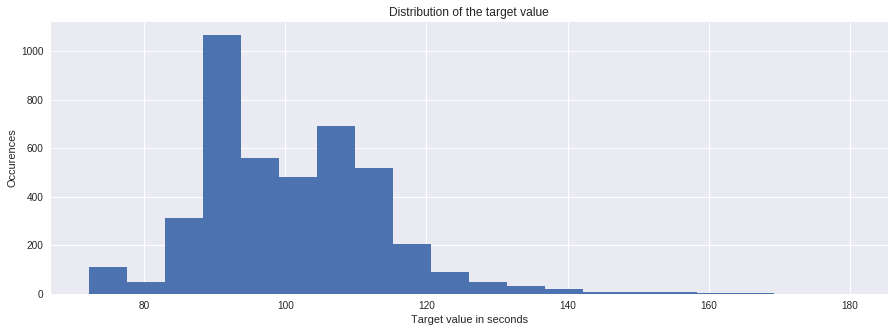

In [4]:
y_train = df_train['y'].values
plt.figure(figsize=(15, 5))
plt.hist(y_train, bins=20)
plt.xlabel('Target value in seconds')
plt.ylabel('Occurences')
plt.title('Distribution of the target value')

print('min: {} max: {} mean: {} std: {}'.format(min(y_train), max(y_train), y_train.mean(), y_train.std()))
print('Count of values above 180: {}'.format(np.sum(y_train > 200)))

So we have a pretty standard distribution here, which is centred around almost exactly 100. Nothing special to note here, except there is a single outlier at 265 seconds where every other value is below 180.

The fact that our ID is not equal to the row ID seems to suggest that the train and test sets were randomly sampled from the same dataset, which could have some special order to it, for example a time series. Let's take a look at how this target value changes over time in order to understand whether we're given time series data.

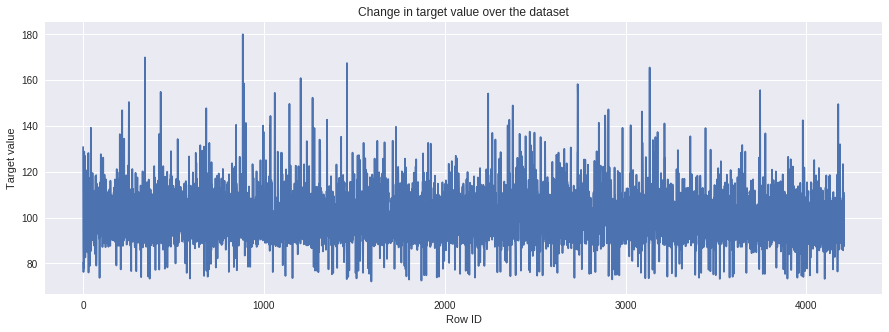

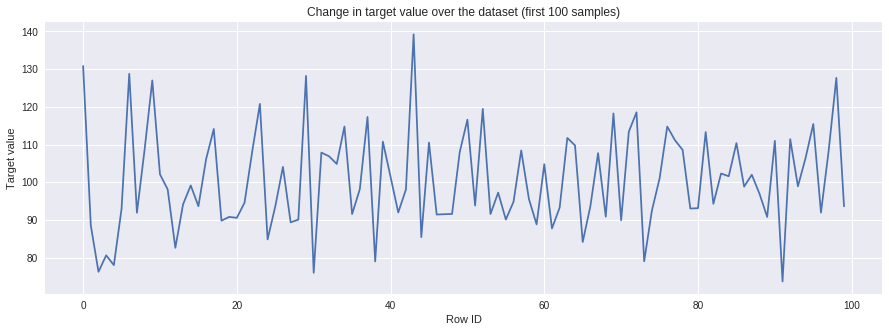

In [5]:
plt.figure(figsize=(15, 5))
plt.plot(y_train)
plt.xlabel('Row ID')
plt.ylabel('Target value')
plt.title('Change in target value over the dataset')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(y_train[:100])
plt.xlabel('Row ID')
plt.ylabel('Target value')
plt.title('Change in target value over the dataset (first 100 samples)')
print()

At first glance, there doesn't seem to be anything overly suspicious here - looks like how a random sort would. I might take a closer look later but for now let's move on to the features.

## Feature analysis

In [6]:
cols = [c for c in df_train.columns if 'X' in c]
print('Number of features: {}'.format(len(cols)))

print('Feature types:')
df_train[cols].dtypes.value_counts()

Number of features: 376
Feature types:


int64     368
object      8
dtype: int64

So out of all our features, we are given 8 object (likely a string) variables, 368 integer variables. What about the cardinality of our features?

In [7]:
counts = [[], [], []]
for c in cols:
    typ = df_train[c].dtype
    uniq = len(np.unique(df_train[c]))
    if uniq == 1: counts[0].append(c)
    elif uniq == 2 and typ == np.int64: counts[1].append(c)
    else: counts[2].append(c)

print('Constant features: {} Binary features: {} Categorical features: {}\n'.format(*[len(c) for c in counts]))

print('Constant features:', counts[0])
print('Categorical features:', counts[2])

Constant features: 12 Binary features: 356 Categorical features: 8

Constant features: ['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347']
Categorical features: ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']


Interestingly, we have 12 features which only have a single value in them - these are pretty useless for supervised algorithms, and should probably be dropped (unless you want to use them for anomaly detection in case a different value appears in the test set)

The rest of our dataset is made up of many binary features, and a few categorical features.

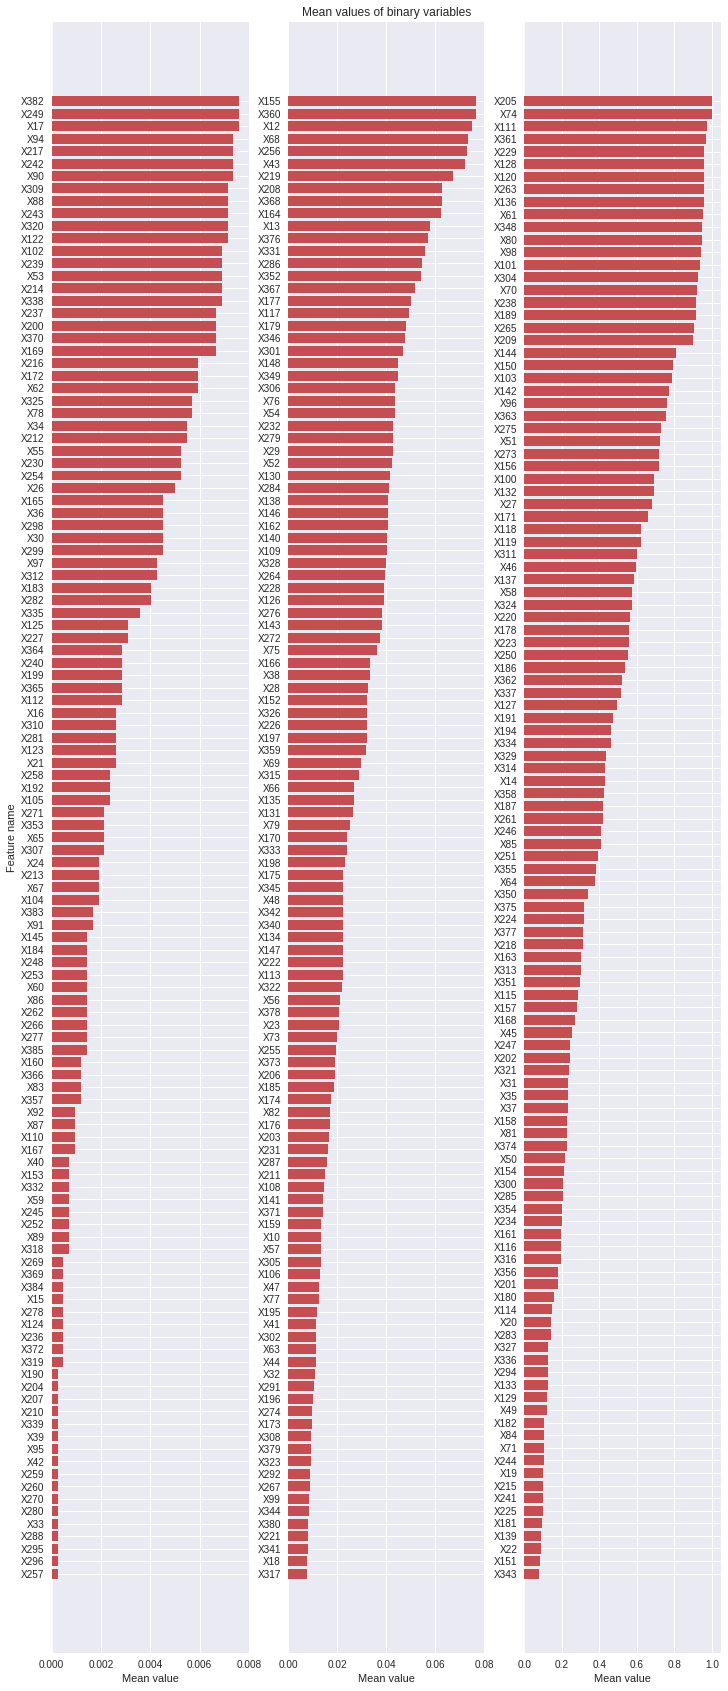

In [8]:
binary_means = [np.mean(df_train[c]) for c in counts[1]]
binary_names = np.array(counts[1])[np.argsort(binary_means)]
binary_means = np.sort(binary_means)

fig, ax = plt.subplots(1, 3, figsize=(12,30))
ax[0].set_ylabel('Feature name')
ax[1].set_title('Mean values of binary variables')
for i in range(3):
    names, means = binary_names[i*119:(i+1)*119], binary_means[i*119:(i+1)*119]
    ax[i].barh(range(len(means)), means, color=pal[2])
    ax[i].set_xlabel('Mean value')
    ax[i].set_yticks(range(len(means)))
    ax[i].set_yticklabels(names, rotation='horizontal')
plt.show()

Columns with mean values of binary variables less than 0.002 are dropped

In [10]:
df_train = df_train.drop(["X190","X204","X207","X210","X339","X39","X95","X42","X259","X260","X70",
                        "X280","X33", "X288","X295","X296","X257","X308","X379","X323","X292",
"X267","X99","X344","X380","X221","X341","X18","X317","X84", "X71", "X244","X19", "X215","X241", 
"X225","X181","X139","X22","X151","X343"],axis = 1)

df_test = df_test.drop(["X190","X204","X207","X210","X339","X39","X95","X42","X259","X260","X70",
                        "X280","X33", "X288","X295","X296","X257","X308","X379","X323","X292",
"X267","X99","X344","X380","X221","X341","X18","X317","X84", "X71", "X244","X19", "X215","X241", 
"X225","X181","X139","X22","X151","X343"],axis = 1)

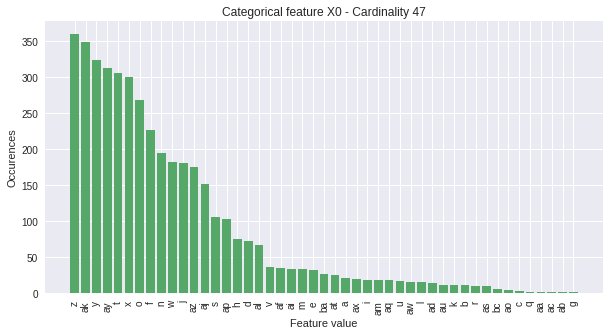

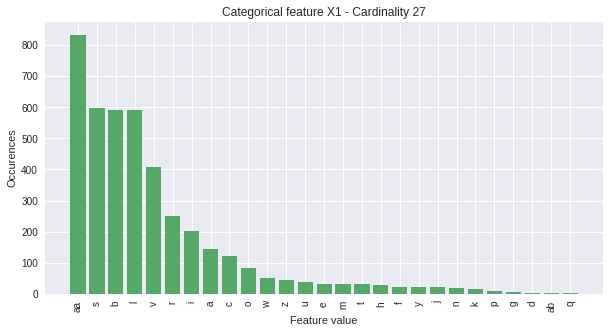

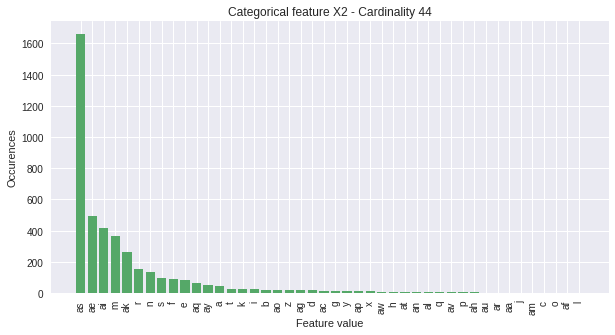

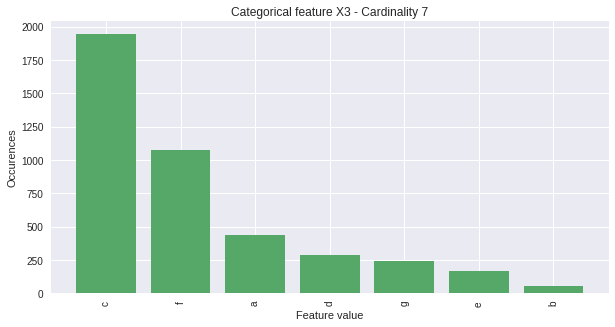

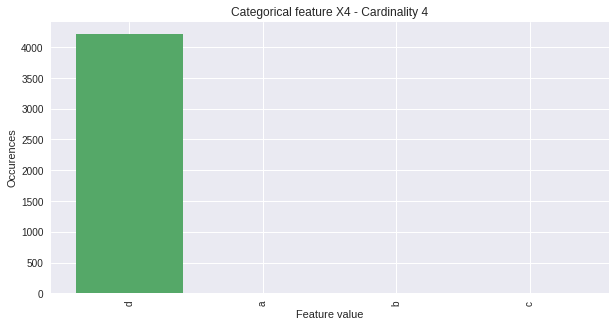

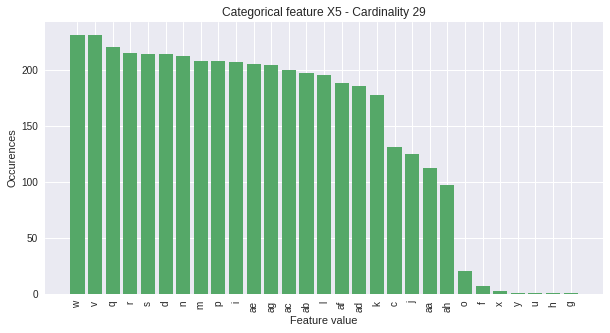

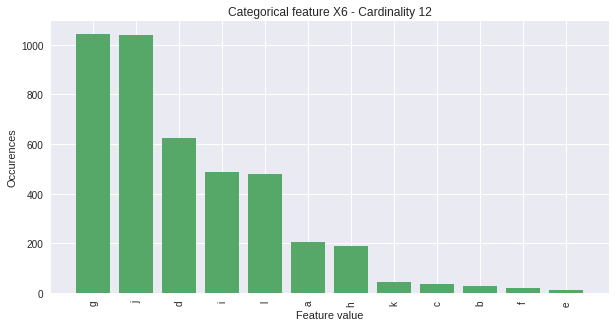

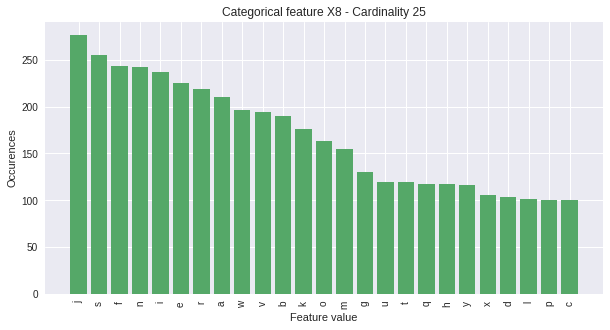

In [11]:
for c in counts[2]:
    value_counts = df_train[c].value_counts()
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.title('Categorical feature {} - Cardinality {}'.format(c, len(np.unique(df_train[c]))))
    plt.xlabel('Feature value')
    plt.ylabel('Occurences')
    plt.bar(range(len(value_counts)), value_counts.values, color=pal[1])
    ax.set_xticks(range(len(value_counts)))
    ax.set_xticklabels(value_counts.index, rotation='vertical')
    plt.show()

In [12]:
usable_columns = list(set(df_train.columns) - set(['ID', 'y']))

y_train = df_train['y'].values
id_test = df_test['ID'].values

x_train = df_train[usable_columns]
x_test = df_test[usable_columns]

for column in usable_columns:
    cardinality = len(np.unique(x_train[column]))
    if cardinality == 1:
        x_train.drop(column, axis=1) # Column with only one value is useless so we drop it
        x_test.drop(column, axis=1)
    if cardinality > 2: # Column is categorical
        mapper = lambda x: sum([ord(digit) for digit in x])
        x_train[column] = x_train[column].apply(mapper)
        x_test[column] = x_test[column].apply(mapper)
        
x_train.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,X48,X383,X81,X153,X324,X271,X243,X128,X236,X360,...,X358,X205,X0,X13,X62,X104,X17,X166,X342,X375
0,0,0,0,0,1,0,0,1,0,0,...,0,0,107,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,1,107,0,0,0,0,0,0,1
2,0,0,0,0,1,0,0,1,0,0,...,1,1,219,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,1,1,219,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,1,0,0,...,1,1,219,0,0,0,0,1,0,0


#  Building the Machine Learning Model : XGBoost 

Now that we know the outline of what the data's made up of, we can make a simple model on it. Time to bring out XGBoost!

In [13]:
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
d_test = xgb.DMatrix(x_test)

params = {}
params['objective'] = 'reg:linear'
params['eta'] = 0.02
params['max_depth'] = 4

def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

clf = xgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, feval=xgb_r2_score, maximize=True, verbose_eval=10)

[0]	train-rmse:99.0839	valid-rmse:98.2542	train-r2:-60.5715	valid-r2:-67.6253


Multiple eval metrics have been passed: 'valid-r2' will be used for early stopping.



Will train until valid-r2 hasn't improved in 50 rounds.


[10]	train-rmse:81.1244	valid-rmse:80.276	train-r2:-40.274	valid-r2:-44.8093


[20]	train-rmse:66.4768	valid-rmse:65.6046	train-r2:-26.7149	valid-r2:-29.595


[30]	train-rmse:54.5428	valid-rmse:53.6412	train-r2:-17.6573	valid-r2:-19.454


[40]	train-rmse:44.8346	valid-rmse:43.8971	train-r2:-11.6067	valid-r2:-12.6979


[50]	train-rmse:36.9546	valid-rmse:35.9733	train-r2:-7.56468	valid-r2:-8.19905


[60]	train-rmse:30.5784	valid-rmse:29.5449	train-r2:-4.86411	valid-r2:-5.20507


[70]	train-rmse:25.4416	valid-rmse:24.3511	train-r2:-3.0594	valid-r2:-3.21522


[80]	train-rmse:21.3281	valid-rmse:20.1802	train-r2:-1.85285	valid-r2:-1.8949


[90]	train-rmse:18.0603	valid-rmse:16.8643	train-r2:-1.04562	valid-r2:-1.02171


[100]	train-rmse:15.491	valid-rmse:14.249	train-r2:-0.504979	valid-r2:-0.443274


[110]	train-rmse:13.4933	valid-rmse:12.21	train-r2:-0.14185	valid-r2:-0.059778


[120]	train-rmse:11.9656	valid-rmse:10.6588	train-r2:0.102062	valid-r2:0.192389


[130]	train-rmse:10.8179	valid-rmse:9.51149	train-r2:0.266057	valid-r2:0.356899


[140]	train-rmse:9.96632	valid-rmse:8.68695	train-r2:0.377063	valid-r2:0.463565


[150]	train-rmse:9.34633	valid-rmse:8.10007	train-r2:0.452157	valid-r2:0.533599


[160]	train-rmse:8.9018	valid-rmse:7.69401	train-r2:0.503031	valid-r2:0.579189


[170]	train-rmse:8.58333	valid-rmse:7.43206	train-r2:0.537954	valid-r2:0.607355


[180]	train-rmse:8.35376	valid-rmse:7.26545	train-r2:0.562339	valid-r2:0.624762


[190]	train-rmse:8.19696	valid-rmse:7.1582	train-r2:0.578615	valid-r2:0.635758


[200]	train-rmse:8.08512	valid-rmse:7.09119	train-r2:0.590035	valid-r2:0.642546


[210]	train-rmse:8.00582	valid-rmse:7.05713	train-r2:0.598038	valid-r2:0.645972


[220]	train-rmse:7.94732	valid-rmse:7.04269	train-r2:0.603891	valid-r2:0.647419


[230]	train-rmse:7.90357	valid-rmse:7.03729	train-r2:0.60824	valid-r2:0.647959


[240]	train-rmse:7.86669	valid-rmse:7.04183	train-r2:0.611887	valid-r2:0.647505


[250]	train-rmse:7.83869	valid-rmse:7.05335	train-r2:0.614645	valid-r2:0.646351


[260]	train-rmse:7.81373	valid-rmse:7.06397	train-r2:0.617095	valid-r2:0.645285


[270]	train-rmse:7.79265	valid-rmse:7.07286	train-r2:0.619158	valid-r2:0.644391


Stopping. Best iteration:
[229]	train-rmse:7.90772	valid-rmse:7.03567	train-r2:0.607828	valid-r2:0.648121



In [14]:
p_test = clf.predict(d_test)

sub = pd.DataFrame()
sub['ID'] = id_test
sub['y'] = p_test
sub.to_csv('xgb.csv', index=False)

In [15]:
sub.head()

,ID,y
0,1,90.614906
1,2,107.295937
2,3,90.659637
3,4,77.920227
4,5,111.099762
